# Imports 
Necessary imports, based in part on [this](https://www.kaggle.com/code/awsaf49/planttraits2024-kerascv-starter-notebook)

In [15]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt

In [16]:
import model

nn = model.Model("model1")

print(nn.name) # model1

model1


# Data pre-processing

## Loading
The general format of each instance of the data is 
```
[ids*, ancillary data*, trait means*, traits sd*, image path]
```

In [17]:
from config import config
DATA_PATH = "../data"

# creating df that has image path and related ancillary data
df = pd.read_csv(DATA_PATH + "/train.csv")
df['image_path'] = f'{DATA_PATH}/train_images/' + str(df['id']) + '.jpeg'
df.loc[:, config.aux_class_names] = df.loc[:, config.aux_class_names].fillna(-1)
display(df.head(2))

# same df but for the test data
test_df = pd.read_csv(DATA_PATH + "/test.csv")
df['image_path'] = f'{DATA_PATH}/test_images'+ str(test_df['id']) + '.jpeg'
FEATURE_COLS = list(test_df.columns[1:-1])
display(test_df.head(2))

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,../data/train_images/0 192027691\n1 ...
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,../data/train_images/0 192027691\n1 ...


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m03,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12
0,195066138,10.55810,961.500000,31.586735,13.728325,648.038208,25.351532,127,152,137,...,0.440003,0.469694,0.455849,0.528211,0.555653,0.549882,0.542905,0.517507,0.462724,0.427107
1,195524180,7.00287,1120.025513,23.000000,7.258863,973.889404,39.135712,106,167,127,...,0.434866,0.428838,0.456266,0.470074,0.468038,0.475943,0.483206,0.477197,0.432732,0.423728


## traits

### mean traits

,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
0,0.401753,11.758108,0.117484,1.243779,1.849375,50.216034
1,0.480334,15.748846,0.389315,0.642940,1.353468,574.098472


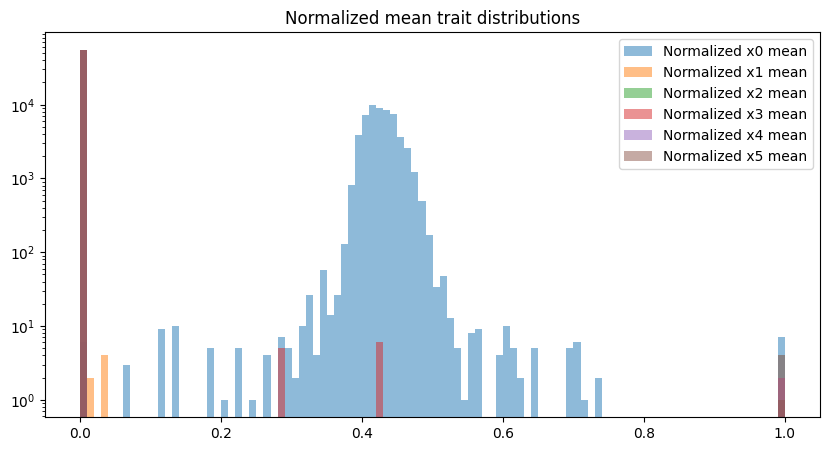

In [18]:
mean_traits = df.iloc[:, 164:170]
sd_traits = df.iloc[:, 170:176]
display(mean_traits.head(2))

def mean_normalizer(col):
    mean = mean_traits.iloc[:, col]
    return (mean - mean.min()) / (mean.max() - mean.min())

plt.figure(figsize=(10, 5))
for i in range(6): 
    plt.hist(mean_normalizer(i), log=True, bins=100, alpha=0.5, label=f'Normalized x{i} mean')
    
plt.title('Normalized mean trait distributions')
plt.legend()
plt.show()

### sd traits

,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
0,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054
1,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477


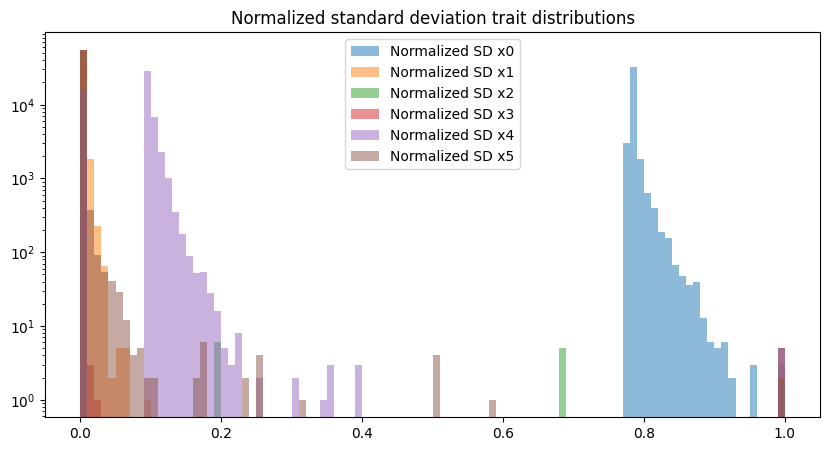

In [14]:
sd_traits = df.iloc[:, 170:176]
display(sd_traits.head(2))
def sd_normalizer(col):
    sd = sd_traits.iloc[:, col]
    return (sd - sd.min()) / (sd.max() - sd.min())

plt.figure(figsize=(10, 5))
for i in range(6):  
    plt.hist(sd_normalizer(i), log=True, bins=100, alpha=0.5, label=f'Normalized SD x{i}')

plt.title('Normalized standard deviation trait distributions')
plt.legend()
plt.show()


## ancillary data

## missing data

### where ?

### how much ?

## data augmentation

## data split